<a href="https://colab.research.google.com/github/ceydab/NLP_Projects/blob/main/WordEmbeddingsWithCBOWandSkipgram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Machine Learning for Natural Language Processing: Word Embeddings with Pytorch

This notebook shows an example of how to use word embeddings with a Skipgram and a CBOW model.
We will use two different datasets, dataset of comments on hotels, an extract from a science fiction text. While the datasets includes different domains, we will use the same preprocessing techniques as they are applicable. We will then obtain the word embeddings using both Skipgram and CBOW. Then, we will visualize the results, and observe whether we have the same/similar embeddings.

In [ ]:
import pandas as pd
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
import string
import re
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
torch.manual_seed(1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
device = torch.device('cuda')

In [ ]:
download_link = 'https://drive.google.com/uc?id=1foE1JuZJeu5E_4qVge9kExzhvF32teuF'
hotels_df = pd.read_csv(download_link)
hotel_comments = hotels_df['Review']
hotel_txt = ["\n".join(hotel_comments)][0]

In [ ]:
print(hotel_txt[:40])

fantastic service large hotel caters bus


In [ ]:
file_id = '13IWXrTjGTrfCd9l7dScZVO8ZvMicPU75'
download_link = f'https://drive.google.com/uc?id={file_id}'
txt_destination_path = '/content/dataset.txt'

txt_response = requests.get(download_link)
with open(txt_destination_path, 'wb') as txt_file:
    txt_file.write(txt_response.content)

with open(txt_destination_path, 'r') as txt_file:
    scifi_txt = txt_file.read()


In [ ]:
print(scifi_txt[:40])

 A chat with the editor  i #  science fi


We have imported the dataset as continuous text files as desired. Now, we need to define the preprocessing steps. We will do as following:
1. lowercase
2. remove numbers
3. remove punctuation
4. remove whitespaces
5. remove stopwords for english
6. tokenize
7. lemmatize

What can lead to wrong results is about the hotel reviews dataset. As this set includes reviews, it may include numbers, as well as stars (*). If the goal of the analyzer is to see whether a number indicates a certain comment, it may be wiser to keep the numbers. Yet we are only interested in words, so we choose to remove them.

In [ ]:
def preprocess_tokenize(text):
  text = text.lower()
  text = re.sub(r'\d+', '', text)
  text = text.translate(str.maketrans("","", string.punctuation))
  text = text.strip()
  tokenized_text = word_tokenize(text)
  tokens = [i for i in tokenized_text if not i in stop_words]
  lemmatizer = WordNetLemmatizer()
  lemmatized_text = []
  for word in tokens:
    lemmatized_text.append(lemmatizer.lemmatize(word))
  return lemmatized_text[:30000]

Next, we will prepare the variables that will be sent into the training algorithm. To make things faster we have limited the length to 150000 in lemmatizing. Now, we will also limit the number of target words we want to see depending on the frequency of the word occurring.

In [ ]:
def prepare_data(text, context_size):
  lemmatized_text = preprocess_tokenize(text)

  data = []
  for i in range(context_size, len(lemmatized_text) - context_size):
    context = lemmatized_text[i - context_size:i] + lemmatized_text[i + 1:i + context_size + 1]
    target = lemmatized_text[i]
    data.append((context, target))

  vocab = set(lemmatized_text)
  vocab_size = len(vocab)



  word_to_ix = {word: i for i, word in enumerate(vocab)}
  ix_to_word = {i: word for i, word in enumerate(vocab)}


  return vocab, vocab_size, word_to_ix, ix_to_word, lemmatized_text, data

Here, we will provide the vectorization.

In [ ]:
def make_context_vector(context, word_to_ix, device):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long, device=device)


Now, we will define CBOW and Skipgram modules. Then, we will also implement the training functions. Note that we will not be using a test set as we only want to observe the targets and contexts.

In [ ]:
class CBOW(nn.Module):

    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size,embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        embeds = torch.sum(embeds, dim =0).view(1,-1)
        out1 = F.relu(self.linear1(embeds))
        out2 = self.linear2(out1)
        probs = F.log_softmax(out2, dim=1)
        return probs

In [ ]:
class SkipGram(nn.Module):

    def __init__(self, vocab_size, embedding_dim):
        super(SkipGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        out1 = self.linear1(embeds)
        out2 = self.linear2(F.relu(out1))
        probs = F.log_softmax(out2, dim=1)
        return probs

In [ ]:
def training_cbow(vocab_size, word_to_ix, data, epochs=30, eta=0.1 ):
  device = torch.device('cuda')
  loss = []
  loss_fn = nn.NLLLoss()
  model = CBOW(vocab_size, embedding_dim = 50).to(device)
  optimizer = optim.SGD(model.parameters(), lr= eta)

  for epoch in range(epochs):
    total_loss = 0.0

    for context, target in tqdm(data):
      context_ix = make_context_vector(context, word_to_ix, device)
      model.zero_grad()
      probs = model(context_ix)
      loss_train = loss_fn(probs, torch.tensor([word_to_ix[target]], dtype=torch.long, device=device))
      loss_train.backward()
      optimizer.step()
      total_loss += loss_train.item()
    loss.append(total_loss)

  embeddings = model.embeddings.weight.data.cpu().numpy()
  return embeddings, loss

In [ ]:
def training_skipgram(vocab_size, word_to_ix, data, epochs=30, eta=0.1 ):
  device = torch.device('cuda')
  loss = []
  loss_fn = nn.NLLLoss()
  model = SkipGram(vocab_size, embedding_dim = 50).to(device)
  optimizer = optim.SGD(model.parameters(), lr= eta)

  for epoch in range(epochs):
    total_loss = 0.0

    for context, target in tqdm(data):
      context_ix = make_context_vector(context, word_to_ix, device)
      model.zero_grad()

      probs = model(context_ix)
      loss_train = loss_fn(probs, torch.tensor([word_to_ix[target]], dtype=torch.long, device=device).repeat(context_ix.size(0)))
      loss_train.backward()
      optimizer.step()
      total_loss += loss_train.item()
    loss.append(total_loss)
  embeddings = model.embeddings.weight.data.cpu().numpy()
  return embeddings, loss


As seen, the difference between CBOW and Skipgram is about inputs and outputs only.

Now, let's call the functions and work the algorithms.

In [ ]:
vocab_scifi, vocab_size_scifi, word_to_ix_scifi, ix_to_word_scifi, lemmatized_text, data = prepare_data(scifi_txt, 2)
cbow_embeddings_scifi, cbow_loss_scifi = training_cbow(vocab_size_scifi, word_to_ix_scifi, data, epochs = 8)
skipgram_embeddings_scifi, skipgram_loss_scifi = training_skipgram(vocab_size_scifi, word_to_ix_scifi, data, epochs = 17)

100%|██████████| 29996/29996 [00:39<00:00, 763.56it/s]


In [ ]:
vocab_hotel, vocab_size_hotel, word_to_ix_hotel, ix_to_word_hotel, lemmatized_text, data = prepare_data(hotel_txt, 2)
cbow_embeddings_hotel, cbow_loss_hotel = training_cbow(vocab_size_hotel, word_to_ix_hotel, data, epochs = 8)
skipgram_embeddings_hotel, skipgram_loss_hotel = training_skipgram(vocab_size_hotel, word_to_ix_hotel, data, epochs = 17)

100%|██████████| 29996/29996 [00:46<00:00, 650.08it/s]


Let's visualize what we have.

We will first observe the loss graphs.

Then, we will use scatter plots to observe word distribution.

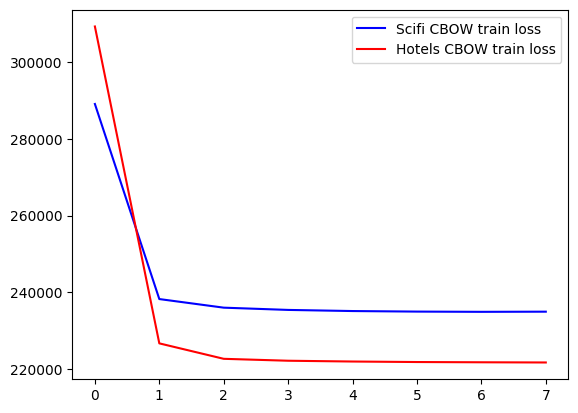

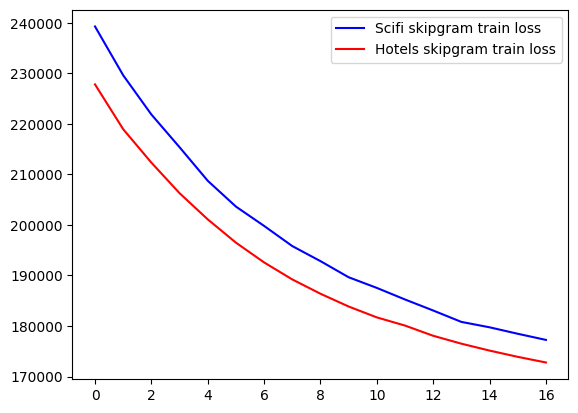

In [ ]:
plt.figure(1)
plt.plot(cbow_loss_scifi, "b-", label="Scifi CBOW train loss")
plt.plot(cbow_loss_hotel, "r-", label="Hotels CBOW train loss")
plt.legend()

plt.figure(2)
plt.plot(skipgram_loss_scifi, "b-", label="Scifi skipgram train loss")
plt.plot(skipgram_loss_hotel, "r-", label="Hotels skipgram train loss")
plt.legend()

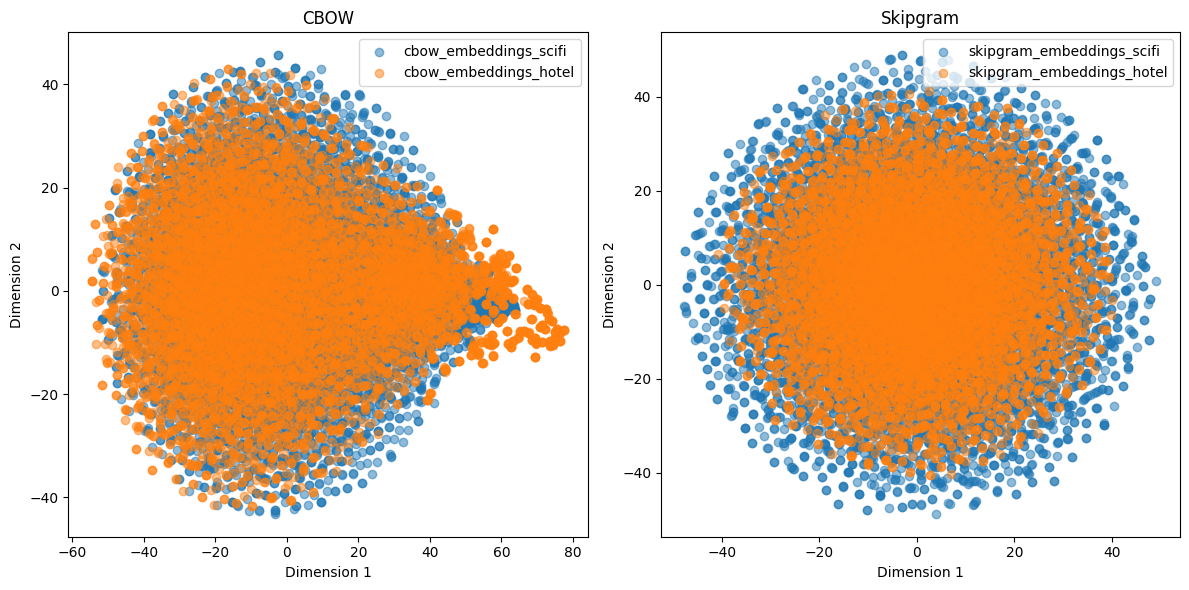

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d_1 = tsne.fit_transform(cbow_embeddings_scifi)
embeddings_2d_2 = tsne.fit_transform(cbow_embeddings_hotel)
embeddings_2d_3 = tsne.fit_transform(skipgram_embeddings_scifi)
embeddings_2d_4 = tsne.fit_transform(skipgram_embeddings_hotel)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(embeddings_2d_1[:, 0], embeddings_2d_1[:, 1], alpha=0.5, label='cbow_embeddings_scifi')
plt.scatter(embeddings_2d_2[:, 0], embeddings_2d_2[:, 1], alpha=0.5, label='cbow_embeddings_hotel')
plt.title('CBOW')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(embeddings_2d_3[:, 0], embeddings_2d_3[:, 1], alpha=0.5, label='skipgram_embeddings_scifi')
plt.scatter(embeddings_2d_4[:, 0], embeddings_2d_4[:, 1], alpha=0.5, label='skipgram_embeddings_hotel')
plt.title('Skipgram')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

plt.tight_layout()
plt.show()


We have observed that same words may have similar to different contexts in different domains.

We have also observed that for Skipgram and CBOW, target-context pairs may be different.

Let's now observe this in words. We will first get all target-context pairs for all 4 embeddings.

In [ ]:
def get_similar_words(embeddings, word_to_ix, ix_to_word, vocab, top_n=5):

  similar_list = []
  for target_word in set(vocab):
    target_idx = word_to_ix[target_word]
    target_embedding = embeddings[target_idx]

    similarities = cosine_similarity([target_embedding], embeddings)[0]
    similar_indices = similarities.argsort()[::-1][1:top_n+1]
    similar_words = [ix_to_word[idx] for idx in similar_indices]
    similar_list.append((target_word, similar_words))
  return similar_list


similar_words_cbow_hotel = get_similar_words(cbow_embeddings_hotel, word_to_ix_hotel, ix_to_word_hotel, vocab_hotel)
similar_words_skipgram_hotel = get_similar_words(skipgram_embeddings_hotel, word_to_ix_hotel, ix_to_word_hotel, vocab_hotel)
similar_words_cbow_scifi = get_similar_words(cbow_embeddings_scifi, word_to_ix_scifi, ix_to_word_scifi, vocab_scifi)
similar_words_skipgram_scifi = get_similar_words(skipgram_embeddings_scifi, word_to_ix_scifi, ix_to_word_scifi, vocab_scifi)
print("Target-Context pairs using CBOW model for hotel reviews:", similar_words_cbow_hotel)
print("Target-Context pairs using SkipGram model for hotel reviews:", similar_words_skipgram_hotel)
print("Target-Context pairs using CBOW model for scifi:", similar_words_cbow_scifi)
print("Target-Context pairs using SkipGram model for scifi:", similar_words_skipgram_scifi)

Target-Context pairs using CBOW model for hotel reviews: [('outfit', ['refined', 'crawling', 'frontsfirst', 'nervous', 'tryp']), ('variation', ['expand', 'beachour', 'alright', 'lobbyphoto', 'twicenot']), ('track', ['notwithstanding', 'needle', 'note', 'coral', 'gas']), ('mall', ['unless', 'offered', 'hanging', 'married', 'ball']), ('broadway', ['noncooked', 'paragliding', 'early', 'peep', 'ocassion']), ('nightpm', ['washclothes', 'guaranteed', 'serviceminded', 'sizeçî\x94åreakfast', 'esp']), ('eager', ['alcoholthe', 'brick', 'replacement', 'hesitate', 'rely']), ('etcinternetinternet', ['worked', 'married', 'fifty', 'exercise', 'comforter']), ('komaneka', ['tangled', 'madison', 'understanding', 'conveniant', 'seminyak']), ('enterance', ['ambiance', 'fixins', 'respect', 'friendliness', 'againproblem']), ('barefoot', ['dropoff', 'becuase', 'jumped', 'streetguest', 'nervous']), ('visible', ['assisting', 'record', 'bear', 'rainy', 'yudy']), ('form', ['pineapple', 'canadian', 'print', 'disg

By going through the outputs, it is visible to see the differences between embeddings. To make the observation easier, we implemented the below functions.

First function allows using Skipgram embeddings to find the context (nearest neighbors). If you would like to observe for a specific word, input the desired word inside target list.

Second function utilizes CBOW to find the top possible target words given the context. To observe for a specific word, input the desired contexts inside context_words list.

In [ ]:
def find_nearest_neighbors(embeddings, word_to_ix, ix_to_word, vocab, num_neighbors=5):
  targets = set(vocab)
  neighbor_list = []
  for target_word in targets:
    if target_word not in word_to_ix:
            continue
    target_idx = word_to_ix.get(target_word)
    target_embedding = embeddings[target_idx].reshape(1, -1)
    similarities = cosine_similarity(target_embedding, embeddings)[0]
    nearest_indices = np.argsort(similarities)[::-1][1:num_neighbors+1]
    nearest_words = [ix_to_word[idx] for idx in nearest_indices]
    neighbor_list.append((target_word, nearest_words))
  return neighbor_list

target = ['worth', 'mountain'] # adjust input as desired
skipgram_neighbors_scifi = find_nearest_neighbors(skipgram_embeddings_scifi, word_to_ix_scifi, ix_to_word_scifi, target)
skipgram_neighbors_hotel = find_nearest_neighbors(skipgram_embeddings_hotel, word_to_ix_hotel, ix_to_word_hotel, target)

print("Nearest neighbors using SkipGram for hotel reviews:", skipgram_neighbors_hotel)
print("Nearest neighbors using SkipGram for scifi:", skipgram_neighbors_scifi)

Nearest neighbors using SkipGram for hotel reviews: [('worth', ['verde', 'weather', 'cooky', 'rd', 'sister'])]
Nearest neighbors using SkipGram for scifi: [('worth', ['doublecross', 'nervous', 'cataract', 'survived', 'iris'])]


In [ ]:
def find_target_word(embeddings, word_to_ix, ix_to_word, context_words, top_n = 5):
    context_embeddings = np.array([embeddings[word_to_ix[word]] for word in context_words if word in word_to_ix])
    if len(context_embeddings) == 0:
        print("None of the context words found in vocabulary.")
        return

    avg_context_embedding = np.mean(context_embeddings, axis=0).reshape(1, -1)
    similarities = np.dot(avg_context_embedding, embeddings.T)

    top_indices = np.argsort(similarities[0])[::-1][:top_n]

    target_words = [ix_to_word[idx] for idx in top_indices]
    return target_words

context_words = ['grin', 'videodirectory', 'clearly',] #adjust input as desired
cbow_target_scifi = find_target_word(cbow_embeddings_scifi, word_to_ix_scifi, ix_to_word_scifi, context_words)
cbow_target_hotel = find_target_word(skipgram_embeddings_hotel, word_to_ix_hotel, ix_to_word_hotel, context_words)

print("Target word for context '{}' using CBOW for scifi:".format(context_words), cbow_target_scifi)
print("Target word for context '{}' using CBOW for hotel reviews:".format(context_words), cbow_target_hotel)


Target word for context '['grin', 'videodirectory', 'clearly']' using CBOW for scifi: ['chassis', 'tve', 'eightfoot', 'yield', 'refrigerator']
Target word for context '['grin', 'videodirectory', 'clearly']' using CBOW for hotel reviews: ['clearly', 'checked', 'hail', 'hooter', 'restaurantbar']
